In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
# Publication-ready plot configuration
import matplotlib.pyplot as plt
import matplotlib as mpl

# Font sizes
FONT_SIZE_LABEL = 18  # Axis labels and tick labels
FONT_SIZE_TITLE = 20  # Plot titles
FONT_SIZE_LEGEND = 18  # Legend text

# Configure matplotlib parameters globally
plt.rcParams.update({
    # Font sizes
    'font.size': FONT_SIZE_LABEL,          # Base font size
    'axes.labelsize': FONT_SIZE_LABEL,     # X and Y axis labels
    'axes.titlesize': FONT_SIZE_TITLE,     # Subplot titles
    'xtick.labelsize': FONT_SIZE_LABEL,    # X tick labels
    'ytick.labelsize': FONT_SIZE_LABEL,    # Y tick labels
    'legend.fontsize': FONT_SIZE_LEGEND,   # Legend
    
    # Font family
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
    # Line widths
    'axes.linewidth': 1.5,                 # Axis border width
    'grid.linewidth': 1.0,                 # Grid line width
    'lines.linewidth': 2.0,                # Plot line width
    'lines.markersize': 8,                 # Default marker size
    
    # Tick parameters
    'xtick.major.width': 1.5,              # X tick width
    'ytick.major.width': 1.5,              # Y tick width
    'xtick.major.size': 6,                 # X tick length
    'ytick.major.size': 6,                 # Y tick length
    
    # Legend
    'legend.frameon': True,                # Legend frame
    'legend.framealpha': 0.8,              # Legend transparency
    'legend.edgecolor': 'black',           # Legend border color
    
    # Figure
    'figure.dpi': 100,                     # Display resolution
    'savefig.dpi': 300,                    # Save resolution for publication
    'savefig.bbox': 'tight',               # Tight bounding box
    'savefig.pad_inches': 0.1,             # Padding when saving
    
    # Grid
    'axes.grid': False,                    # No grid by default
    'grid.alpha': 0.3,                     # Grid transparency if enabled
})

print("✓ Publication-ready plot configuration loaded")
print(f"  - Axis labels/ticks: {FONT_SIZE_LABEL}pt")
print(f"  - Titles: {FONT_SIZE_TITLE}pt")
print(f"  - Save resolution: 300 DPI")



✓ Publication-ready plot configuration loaded
  - Axis labels/ticks: 18pt
  - Titles: 20pt
  - Save resolution: 300 DPI


In [3]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)



    
    
    for file_path in json_files:
  
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]=="LapseFree":
                #print("LapseFree model (sharedLambda=False), skipping - we use LapseFix now")
                continue

            # Skip results with specific model types
            excluded_models = ["gaussian_sharedPrior", "fusionOnly_sharedPrior", "probabilityMatching_sharedPrior", "switching_sharedPrior"]
            if any(model in result['modelType'] for model in excluded_models):
                # Skip this result
                os.remove(file_path)
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}\n number of models in comparison is: {len(df_results['modelType'].unique())} ")

Loaded 71 model fit results
Participants: ['all', 'as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']
 number of models in comparison is: 6 


In [4]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os

def loadSimulatedData(mc_fitter, dataName,participantID, modelType=None):
    participantID = dataName.split(".csv")[0]
    #modelType = mc_fitter.modelName

    if mc_fitter.sharedLambda:
        modelType += "_LapseFix"
    else:
        modelType += "_LapseFree"

    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    filename = f"{participantID.split('_')[0]}_{modelType}_simulated.csv"
    filename = os.path.join("simulated_data",participantID.split('_')[0], filename)
    try:
        
        simulatedData= pd.read_csv(filename)
        print(f"Loaded saved simulated data from {filename}")
        return simulatedData
    except:
        print(f"No saved simulated data found at {filename}")
        fitSaver.saveSimulatedData(mc_fitter, mc_fitter.dataName)
        mc_fitter.simulatedData= pd.read_csv(filename)
        print(f"Simulated data saved to {filename}")
        return mc_fitter.simulatedData
#proceed to simulate and save to {filename}
# eg., mc_fitter.simulatedData=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)

# for each participant load simulated data and fit to psychometric functions and save the fitted params in psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json
# no need to plot for now, just save the fitted params
import monteCarloClass

def fitPsychometricFunctions2SimulatedData(participantIDs, modelTypes):
    for participantID in participantIds:
        for modelType in ["lognorm"]:#modelTypes:
            row = df_results[(df_results['participantID'] == participantID) & (df_results['modelType'] == modelType)]
            sharedPrior = 'sharedPrior' in modelType
            modelType=modelType.split("_")[0]
            print(f"Processing participant {participantID}, model {modelType}, sharedPrior: {sharedPrior}")
            if row.empty:
                print(f"No results found for participant {participantID} and model {modelType}, skipping.")
                continue
            result = row.iloc[0].to_dict()
            
            data,dataName=loadData.loadData(participantID+"_all.csv")
            # Initialize monteCarloClass with the model parameters
            tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            tmp_mc_fitter.modelName = result['modelType'].split("_")[0]
            tmp_mc_fitter.sharedLambda = True  # Using sharedLambda=True (LapseFix)
            tmp_mc_fitter.freeP_c = False
            tmp_mc_fitter.dataName = dataName

            print(f"Simulating data for participant {participantID} using\n model {tmp_mc_fitter.modelName} with sharedLambda={tmp_mc_fitter.sharedLambda}, freeP_c={tmp_mc_fitter.freeP_c}")

            tmp_mc_fitter.modelFit= result['fittedParams']
            simulatedData = loadSimulatedData(mc_fitter=tmp_mc_fitter, dataName=tmp_mc_fitter.dataName,participantID=participantID, modelType=tmp_mc_fitter.modelName)
            simulatedData=  tmp_mc_fitter.simulateMonteCarloData(tmp_mc_fitter.modelFit, tmp_mc_fitter.data)

            tmp_mc_fitter.simulatedData = simulatedData
            tmp_mc_fitter.simDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.simulatedData,1)
            # save to psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json without fitSaver function
            save_dir = os.path.join("psychometric_fits_simulated", participantID.split('_')[0])
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{participantID}_{modelType}_psychometricFits.json")
            print(f"Saving psychometric fits for simulated data to {save_path}")
            fit_data = {
                'participantID': participantID,
                'modelType': modelType,
                'fitParams': tmp_mc_fitter.simDataFit.x.tolist(),  # Convert ndarray to list
            }
            # serialize to json
            with open(save_path, 'w') as f:
                json.dump(fit_data, f)
        
        
def fitPsychometric2RealData(participantIDs):
    for participantID in participantIds:
        row = df_results[(df_results['participantID'] == participantID)]
        print(f"Processing participant {participantID}")
        if row.empty:
            print(f"No results found for participant {participantID}, skipping.")
            continue
        result = row.iloc[0].to_dict()
        
        data,dataName=loadData.loadData(participantID+"_all.csv")
        # Initialize monteCarloClass with the model parameters
        tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)

        tmp_mc_fitter.freeP_c = False
        tmp_mc_fitter.dataName = dataName

        
        tmp_mc_fitter.realDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.data,1)
        # save to psychometric_fits_real/participantID/participantID_modelType_psychometricFits.json without fitSaver function
        save_dir = os.path.join("psychometric_fits_real", participantID.split('_')[0])
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{participantID}_psychometricFits.json")
        print(f"Saving psychometric fits for real data to {save_path}")
        fit_data = {
            'participantID': participantID,
            'fitParams': tmp_mc_fitter.realDataFit.x.tolist(),  # Convert ndarray to list
        }
        # serialize to json
        with open(save_path, 'w') as f:
            json.dump(fit_data, f)

        
#fitPsychometricFunctions2SimulatedData(participantIds, modelTypes)

#fitPsychometric2RealData(participantIds)

In [5]:
modelTypes

['fusionOnlyLogNorm_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior']

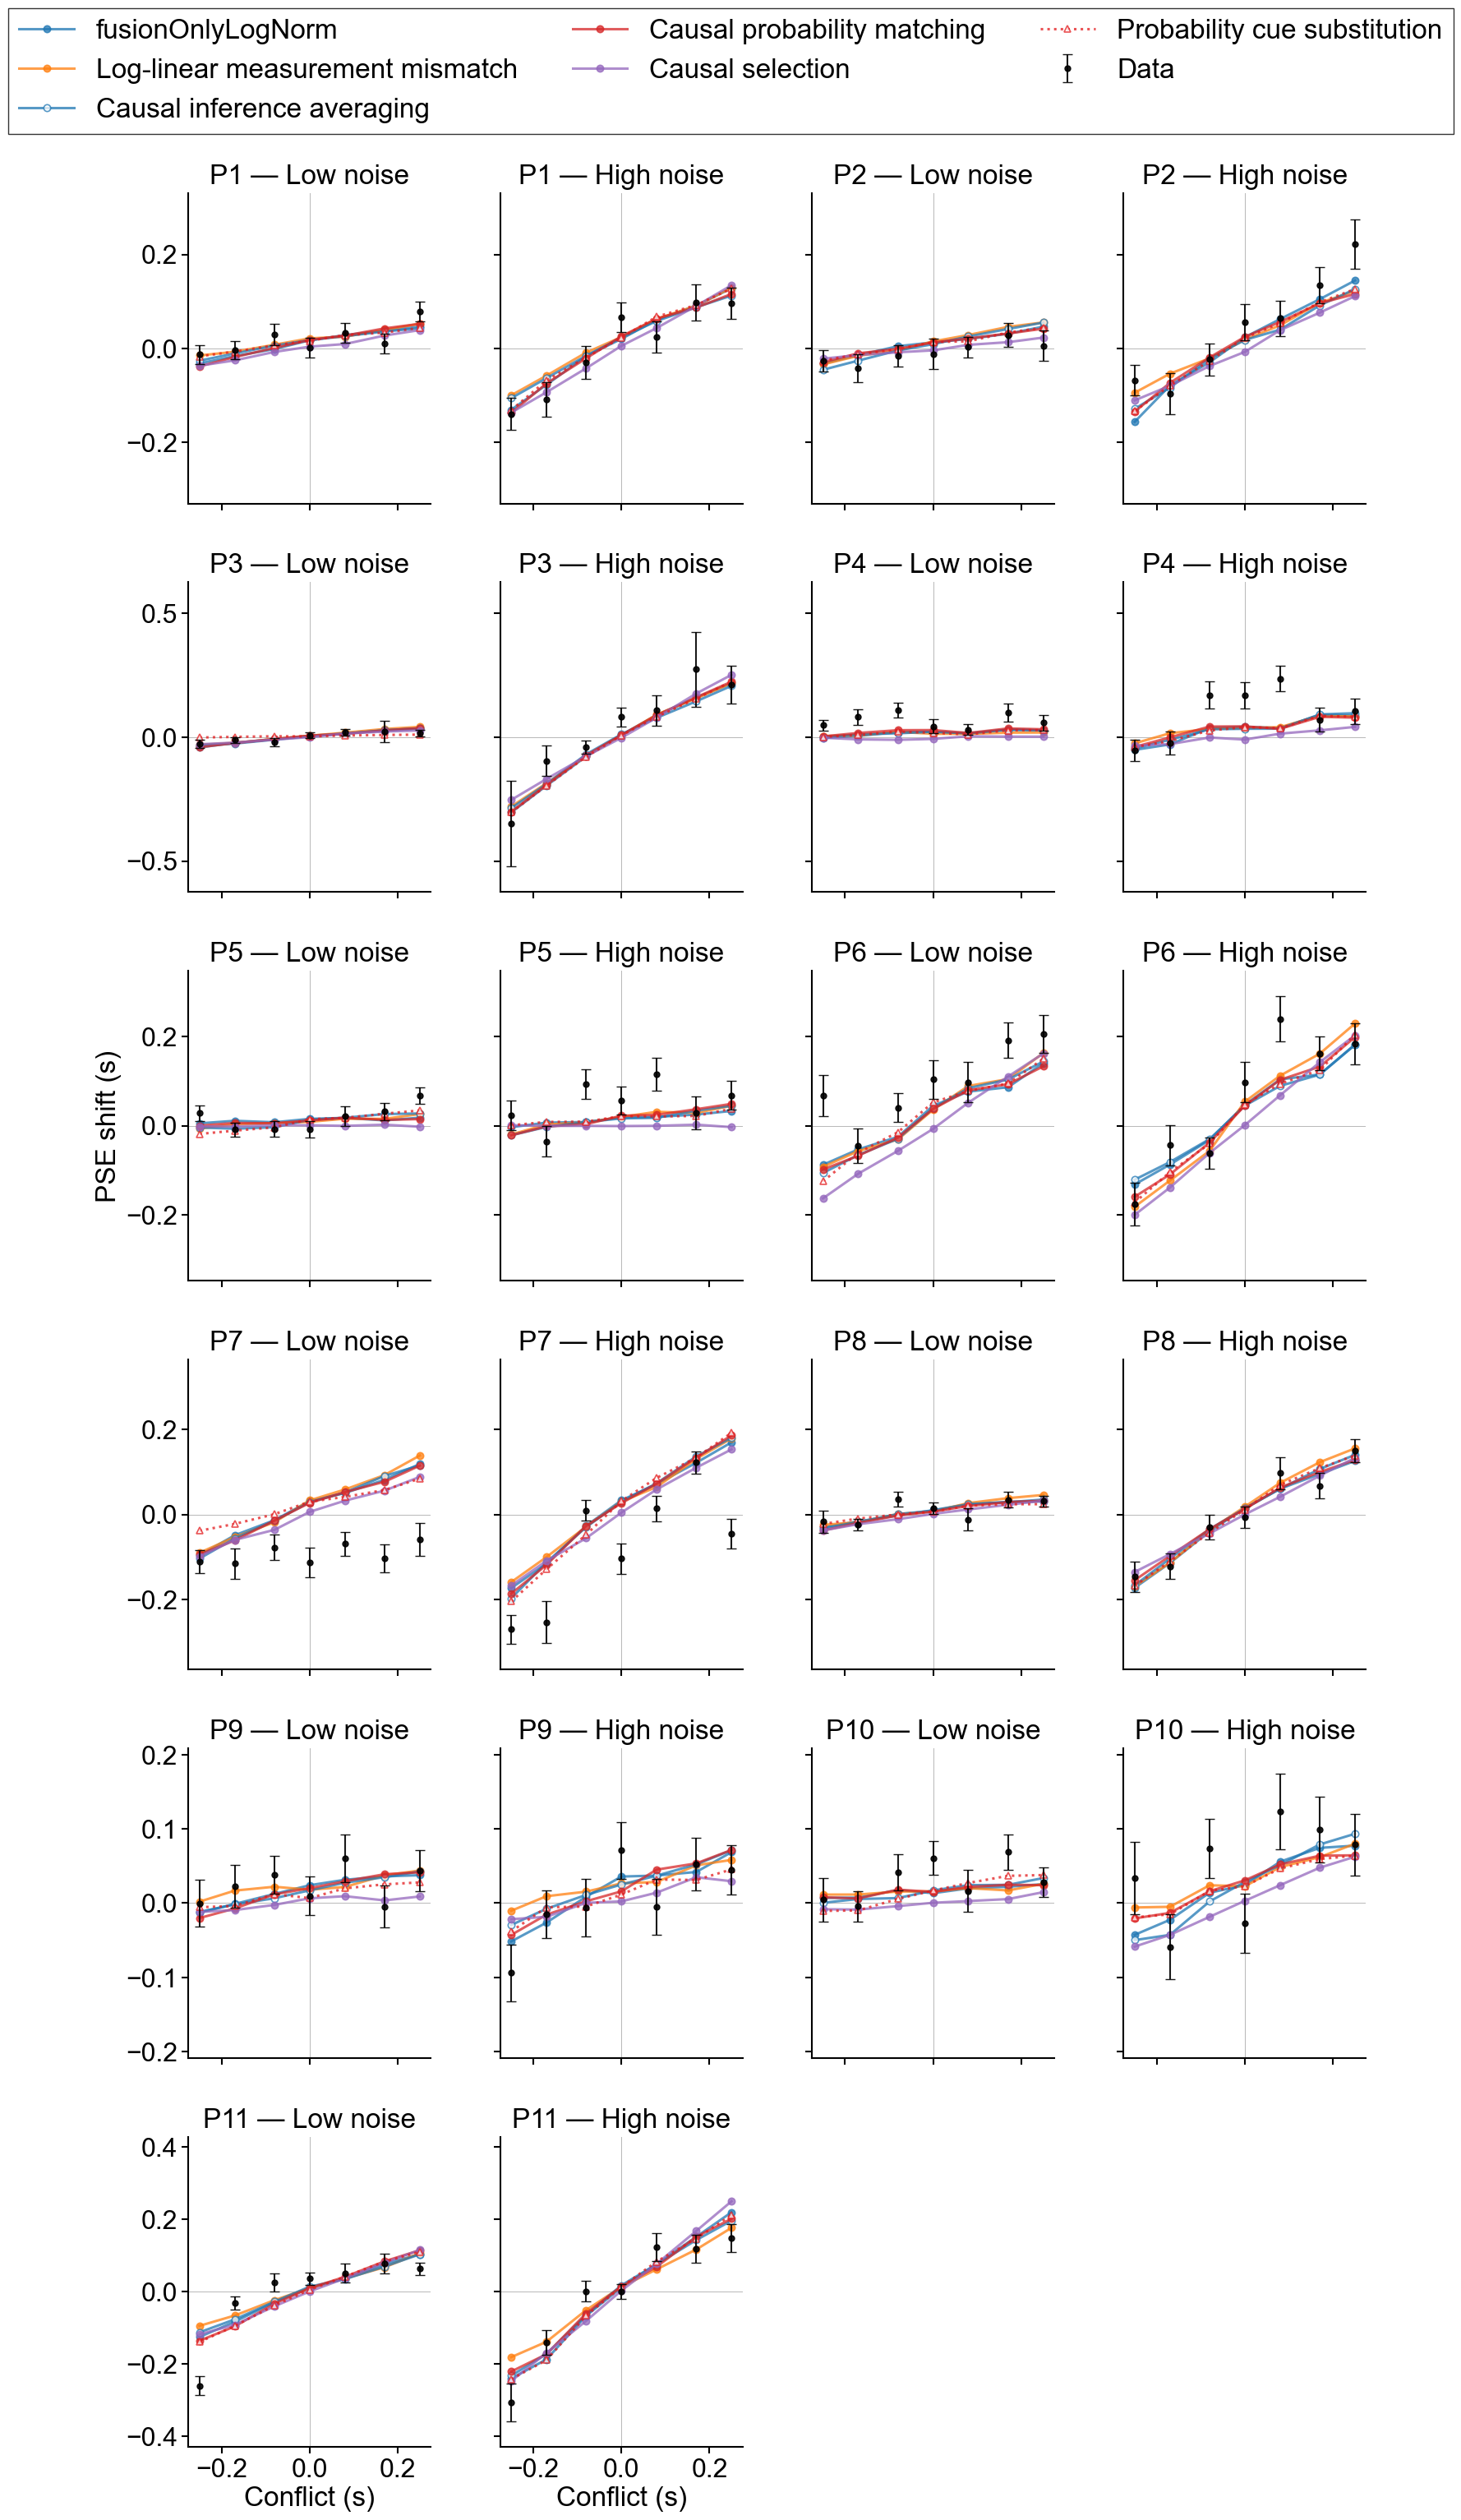

In [6]:

# import bootstrapperSaveLoad functions
import matplotlib.pyplot as plt
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
import loadResults
import os
import json
import seaborn as sns


def plotAsFuncOfConflictAndSensoryNoise(participantIds, modelTypes, parameterToPLot="mu", show_grid=False):
    """
    Plot bootstrapped data (mean ± SD) vs. model predictions across conflict levels,
    for each audio noise level, per participant.
    
    Layout: 4 columns (2 participants per row × 2 noise levels each).
    """
    # Map selected parameter to index in `getParams` output
    param_index_map = {"lambda": 0, "mu": 1, "sigma": 2}
    param_label_map = {
        "mu": "PSE shift (s)",
        "sigma": "Psychometric σ",
        "lambda": "Lapse (λ)",
    }
    if parameterToPLot not in param_index_map:
        raise ValueError("parameterToPLot must be one of 'mu', 'sigma', 'lambda'")
    param_idx = param_index_map[parameterToPLot]
    y_label = param_label_map[parameterToPLot]

    # Colors and styles per base model
    base_model_types = sorted({mt.split("_")[0] for mt in modelTypes})
    palette_fallback = sns.color_palette("tab10", n_colors=max(3, len(base_model_types)))
    fallback_lookup = {m: palette_fallback[i] for i, m in enumerate(base_model_types)}
    model_display_name_map = {
        "lognorm": "Causal inference averaging",
        "fusionOnlyLognorm": "Forced fusion",
        "logLinearMismatch": "Log-linear measurement mismatch",
        "probabilityMatchingLogNorm": "Causal probability matching",
        "selection": "Causal selection",
        "switchingFree": "Probability cue substitution",
    }
    model_style_map = {
        "lognorm":           {"color": "#1f77b4", "linestyle": "-",  "marker": "o", "markerfacecolor": "white"},
        "fusionOnlyLognorm": {"color": "#33a02c", "linestyle": "--", "marker": "s", "markerfacecolor": "#33a02c"},
        "switchingFree":     {"color": "#e31a1c", "linestyle": ":",  "marker": "^", "markerfacecolor": "white"},
    }

    lenSubjs = len(participantIds)
    n_cols = 4  # 2 participants per row × 2 noise levels each
    n_rows = int(np.ceil(lenSubjs / 2))
    
    FONTSIZE = 24
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows),
                             squeeze=False, sharey='row')
    
    # Preload all participant data for consistent y-limits per row
    participant_data = []
    for participantID in participantIds:
        bootPath = participantID + "_dataFit_bootstrapped_params.json"
        dataBootsPath = os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
        try:
            with open(dataBootsPath, 'r') as f:
                content = f.read().strip()
                dataBoots = json.loads(content) if content else []
            if not isinstance(dataBoots, list) or len(dataBoots) == 0:
                print(f"No bootstrapped params for {participantID}")
                participant_data.append(None)
                continue
        except Exception as e:
            print(f"Error loading bootstraps for {participantID}: {e}")
            participant_data.append(None)
            continue

        try:
            data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        except Exception as e:
            print(f"Error loading data for {participantID}: {e}")
            participant_data.append(None)
            continue
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = True
        mc_fitter.dataName = dataName
        
        sensory_levels = sorted(mc_fitter.uniqueSensory)
        conflict_levels = sorted(mc_fitter.uniqueConflict)

        # Robust y-limit per subject: |mean| + 1 SD per condition
        condition_extents = []
        for sensory in sensory_levels:
            for conflict in conflict_levels:
                values = [mc_fitter.getParams(boot, conflict, sensory)[param_idx] for boot in dataBoots]
                condition_extents.append(np.abs(np.mean(values)) + np.std(values))
        max_PSE = max(condition_extents)
        
        participant_data.append({
            'id': participantID, 'boots': dataBoots, 'mc': mc_fitter,
            'sensory': sensory_levels, 'conflict': conflict_levels, 'max_PSE': max_PSE
        })

    legend_handles, legend_labels = [], []
    seen_labels = set()

    for pNum, pdata in enumerate(participant_data):
        if pdata is None:
            continue
        
        row = pNum // 2
        col_offset = (pNum % 2) * 2  # 0 or 2
        
        mc_fitter = pdata['mc']
        dataBoots = pdata['boots']
        sensory_levels = pdata['sensory']
        conflict_levels = pdata['conflict']
        
        # For shared y-axis per row, use max of both participants in that row
        row_partner = pNum + 1 if pNum % 2 == 0 else pNum - 1
        if 0 <= row_partner < len(participant_data) and participant_data[row_partner] is not None:
            row_ylim = max(pdata['max_PSE'], participant_data[row_partner]['max_PSE'])
        else:
            row_ylim = pdata['max_PSE']

        for j, audioNoiseLevel in enumerate(sensory_levels):
            col = col_offset + j
            ax = axes[row, col]

            # --- Titles ---
            noise_label = "Low noise" if j == 0 else "High noise"
            ax.set_title(f"P{pNum + 1} — {noise_label}", fontsize=FONTSIZE, pad=8)

            # --- Axis labels ---
            if row == n_rows - 1:
                ax.set_xlabel("Conflict (s)", fontsize=FONTSIZE)
            else:
                ax.set_xlabel("")
                ax.tick_params(axis="x", labelbottom=False)
            
            if col == 0 and pNum==lenSubjs//2-1:
                ax.set_ylabel(y_label, fontsize=FONTSIZE)
            # sharey handles the rest

            # --- Reference lines ---
            ax.axhline(y=0, color='#888888', linestyle='-', linewidth=0.7, alpha=0.6)
            ax.axvline(x=0, color='#888888', linestyle='-', linewidth=0.7, alpha=0.6)
            
            # --- Spines ---
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.tick_params(labelsize=FONTSIZE - 1)
            if show_grid:
                ax.grid(True, alpha=0.15, linewidth=0.5)

            # --- Bootstrap data (mean ± SD) ---
            data_means, data_stds = [], []
            for conflictLevel in conflict_levels:
                values = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[param_idx] for boot in dataBoots]
                data_means.append(np.mean(values))
                data_stds.append(np.std(values))
            ax.errorbar(
                conflict_levels, data_means, yerr=data_stds,
                color="black", fmt='o', capsize=4, markersize=5,
                alpha=0.9, label="Data", zorder=5, linewidth=1.5,
            )

            # --- Model predictions ---
            for modelType in modelTypes:
                base_model = modelType.split("_")[0]
                mc_fitter.modelName = base_model
                sim_fit_path = os.path.join(
                    "psychometric_fits_simulated",
                    pdata['id'].split('_')[0],
                    f"{pdata['id']}_{base_model}_psychometricFits.json"
                )
                try:
                    with open(sim_fit_path, 'r') as f:
                        sim_fit = json.load(f)
                except Exception as e:
                    print(f"Missing sim fit: {pdata['id']}, {base_model}: {e}")
                    continue
                model_vals = [
                    mc_fitter.getParams(sim_fit['fitParams'], c, audioNoiseLevel)[param_idx]
                    for c in conflict_levels
                ]
                style = model_style_map.get(base_model, {})
                color_m   = style.get('color', fallback_lookup.get(base_model, "#555555"))
                ls        = style.get('linestyle', '-')
                mk        = style.get('marker', 'o')
                mkface    = style.get('markerfacecolor', color_m)
                disp_name = model_display_name_map.get(base_model, base_model)
                ax.plot(
                    conflict_levels, model_vals,
                    color=color_m, alpha=0.75, linestyle=ls, linewidth=2.2,
                    marker=mk, markerfacecolor=mkface, markeredgecolor=color_m,
                    markeredgewidth=1.2, markersize=6, label=disp_name, zorder=4,
                )
            
            # --- Y-limits ---
            if parameterToPLot == "mu":
                ax.set_ylim(-1.2 * row_ylim, 1.2 * row_ylim)

            # Collect legend handles once
            if pNum == 0 and j == 0:
                handles, labels = ax.get_legend_handles_labels()
                for h, l in zip(handles, labels):
                    if l and l not in seen_labels:
                        legend_handles.append(h)
                        legend_labels.append(l)
                        seen_labels.add(l)

    # Hide any unused axes (when odd number of participants)
    for pNum in range(lenSubjs, n_rows * 2):
        row = pNum // 2
        col_offset = (pNum % 2) * 2
        for j in range(2):
            axes[row, col_offset + j].set_visible(False)

    # --- Legend at top ---
        if legend_handles:
            max_cols = 3
            ncol = min(len(legend_labels), max_cols)
            fig.legend(
                legend_handles, legend_labels,
                loc='upper center', ncol=ncol,
                frameon=True, bbox_to_anchor=(0.5, 1.03),
                fontsize=FONTSIZE, edgecolor='black', fancybox=False,
            )

    plt.tight_layout(rect=(0, 0, 1, 0.97), h_pad=2.0, w_pad=1.5)
    fig.savefig("pse_vs_conflict_4col.png", dpi=600, format='png', bbox_inches='tight') 
    plt.show()


# Example call
plotAsFuncOfConflictAndSensoryNoise(participantIds[1:], modelTypes=modelTypes, parameterToPLot="mu")

In [7]:

# Caption and LaTeX
print("\n" + "="*80)
print("FIGURE CAPTION:")
print("="*80)
print("PSE shift as a function of audiovisual conflict and auditory noise for all")
print("participants. Each row shows data for one participant across two noise conditions.")
print("Black points with error bars represent empirical data (mean ± SD from bootstrap")
print("resampling). Colored lines show model predictions. Left column: low noise condition;")
print("Right column: high noise condition.")

print("\n" + "="*80)
print("LATEX IMPLEMENTATION:")
print("="*80)
print("""
% Single full-page figure
\\begin{figure}[p]
    \\centering
    \\includegraphics[width=0.95\\textwidth]{pse_vs_conflict_single_page.png}
    \\caption{PSE shift as a function of audiovisual conflict and auditory noise 
    for all participants. Each row shows data for one participant across two noise 
    conditions. Black points with error bars represent empirical data (mean ± SD 
    from bootstrap resampling). Colored lines show model predictions.}
    \\label{fig:pse_conflict}
\\end{figure}

% Alternative: If figure is too large, use landscape orientation
% Add to preamble: \\usepackage{pdflscape}

\\begin{landscape}
\\begin{figure}[p]
    \\centering
    \\includegraphics[width=\\linewidth]{pse_vs_conflict_single_page.png}
    \\caption{PSE shift as a function of audiovisual conflict and auditory noise.}
    \\label{fig:pse_conflict}
\\end{figure}
\\end{landscape}
""")


FIGURE CAPTION:
PSE shift as a function of audiovisual conflict and auditory noise for all
participants. Each row shows data for one participant across two noise conditions.
Black points with error bars represent empirical data (mean ± SD from bootstrap
resampling). Colored lines show model predictions. Left column: low noise condition;
Right column: high noise condition.

LATEX IMPLEMENTATION:

% Single full-page figure
\begin{figure}[p]
    \centering
    \includegraphics[width=0.95\textwidth]{pse_vs_conflict_single_page.png}
    \caption{PSE shift as a function of audiovisual conflict and auditory noise 
    for all participants. Each row shows data for one participant across two noise 
    conditions. Black points with error bars represent empirical data (mean ± SD 
    from bootstrap resampling). Colored lines show model predictions.}
    \label{fig:pse_conflict}
\end{figure}

% Alternative: If figure is too large, use landscape orientation
% Add to preamble: \usepackage{pdflscap

In [8]:
from collections import defaultdict

def aggregate_bootstrap_parameter(participantIds, parameterToPlot="mu"):
    """
    Aggregate bootstrapped parameter values across participants for grouped plotting.
    
    For each condition (audioNoise, conflict), we:
    1. Compute each participant's mean PSE (across their bootstrap samples)
    2. Then compute mean ± SD across participant means
    
    This gives error bars that reflect between-participant variability,
    not pooled bootstrap variability.
    """
    param_index_map = {"lambda": 0, "mu": 1, "sigma": 2}
    if parameterToPlot not in param_index_map:
        raise ValueError("parameterToPlot must be one of 'mu', 'sigma', 'lambda'")
    param_idx = param_index_map[parameterToPlot]

    # Store participant MEANS (not all bootstrap samples)
    participant_means_by_combo = defaultdict(list)
    contributors_by_combo = defaultdict(set)

    for participantID in participantIds:
        boot_filename = participantID + "_dataFit_bootstrapped_params.json"
        boot_path = os.path.join("bootstrapped_params", participantID.split('_')[0], boot_filename)
        if not os.path.exists(boot_path):
            print(f"Missing bootstrapped params for {participantID} at {boot_path}")
            continue
        try:
            with open(boot_path, 'r') as f:
                content = f.read().strip()
                dataBoots = json.loads(content) if content else []
        except Exception as e:
            print(f"Error reading {boot_path}: {e}")
            continue
        if not isinstance(dataBoots, list) or len(dataBoots) == 0:
            print(f"No bootstrapped samples for {participantID} in {boot_path}")
            continue

        try:
            data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        except Exception as e:
            print(f"Error loading data for {participantID}: {e}")
            continue

        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = True  # Using sharedLambda=True (LapseFix)
        mc_fitter.dataName = dataName

        sensory_levels = sorted(mc_fitter.uniqueSensory)
        conflict_levels = sorted(mc_fitter.uniqueConflict)

        for audioNoiseLevel in sensory_levels:
            for conflictLevel in conflict_levels:
                try:
                    values = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[param_idx] for boot in dataBoots]
                except Exception as e:
                    print(f"Skipping {participantID} ({conflictLevel}, {audioNoiseLevel}): {e}")
                    continue
                if not values:
                    continue
                key = (audioNoiseLevel, conflictLevel)
                # Store the MEAN for this participant (not all bootstrap samples)
                participant_means_by_combo[key].append(np.mean(values))
                contributors_by_combo[key].add(participantID)

    rows = []
    for (audioNoiseLevel, conflictLevel), participant_means in sorted(participant_means_by_combo.items()):
        rows.append({
            "audioNoise": audioNoiseLevel,
            "conflict": conflictLevel,
            "mean": float(np.mean(participant_means)),  # Mean of participant means
            "std": float(np.std(participant_means)),    # SD across participants
            "sem": float(np.std(participant_means) / np.sqrt(len(participant_means))),  # SEM
            "n_participants": len(contributors_by_combo[(audioNoiseLevel, conflictLevel)])
        })

    return pd.DataFrame(rows)


def aggregate_model_predictions(participantIds, modelTypes, parameterToPlot="mu"):
    """
    Aggregate model predictions across participants for grouped plotting.
    
    For each condition, compute mean ± SD across participant model predictions.
    """
    if len(modelTypes) == 0:
        return pd.DataFrame()
    param_index_map = {"lambda": 0, "mu": 1, "sigma": 2}
    if parameterToPlot not in param_index_map:
        raise ValueError("parameterToPlot must be one of 'mu', 'sigma', 'lambda'")
    param_idx = param_index_map[parameterToPlot]

    values_by_combo = defaultdict(list)
    contributors_by_combo = defaultdict(set)

    for participantID in participantIds:
        try:
            data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        except Exception as e:
            print(f"Error loading data for {participantID}: {e}")
            continue

        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = True  # Using sharedLambda=True (LapseFix)
        mc_fitter.dataName = dataName

        sensory_levels = sorted(mc_fitter.uniqueSensory)
        conflict_levels = sorted(mc_fitter.uniqueConflict)

        for modelType in modelTypes:
            base_model = modelType.split("_")[0]
            sim_fit_path = os.path.join(
            "psychometric_fits_simulated",
            participantID.split('_')[0],
            f"{participantID}_{base_model}_psychometricFits.json")
            if not os.path.exists(sim_fit_path):
                print(f"Missing simulated fit for {participantID}, model {base_model}: {sim_fit_path}")
                continue
            try:
                with open(sim_fit_path, 'r') as f:
                    sim_fit = json.load(f)
            except Exception as e:
                print(f"Error reading {sim_fit_path}: {e}")
                continue

            for audioNoiseLevel in sensory_levels:
                for conflictLevel in conflict_levels:
                    try:
                        value = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)[param_idx]
                    except Exception as e:
                        print(f"Skipping model {base_model} for {participantID} ({conflictLevel}, {audioNoiseLevel}): {e}")
                        continue
                    key = (base_model, audioNoiseLevel, conflictLevel)
                    values_by_combo[key].append(value)
                    contributors_by_combo[key].add(participantID)

    rows = []
    for (base_model, audioNoiseLevel, conflictLevel), values in sorted(values_by_combo.items(), key=lambda item: (item[0][1], item[0][2], item[0][0])):
        rows.append({
            "model": base_model,
            "audioNoise": audioNoiseLevel,
            "conflict": conflictLevel,
            "mean": float(np.mean(values)),
            "std": float(np.std(values)),
            "sem": float(np.std(values) / np.sqrt(len(values))),
            "n_participants": len(contributors_by_combo[(base_model, audioNoiseLevel, conflictLevel)])
        })

    return pd.DataFrame(rows)


parameter_to_plot = "mu"
models_to_plot = ['switchingFree_sharedPrior', 'lognorm_sharedPrior', 'fusionOnlyLognorm_sharedPrior']

grouped_data_stats = aggregate_bootstrap_parameter(participantIds[1:], parameter_to_plot)
grouped_model_stats = aggregate_model_predictions(participantIds[1:], models_to_plot, parameter_to_plot)

print(f"Aggregated data rows: {len(grouped_data_stats)}")
print(f"Aggregated model rows: {len(grouped_model_stats)}")

Aggregated data rows: 14
Aggregated model rows: 42


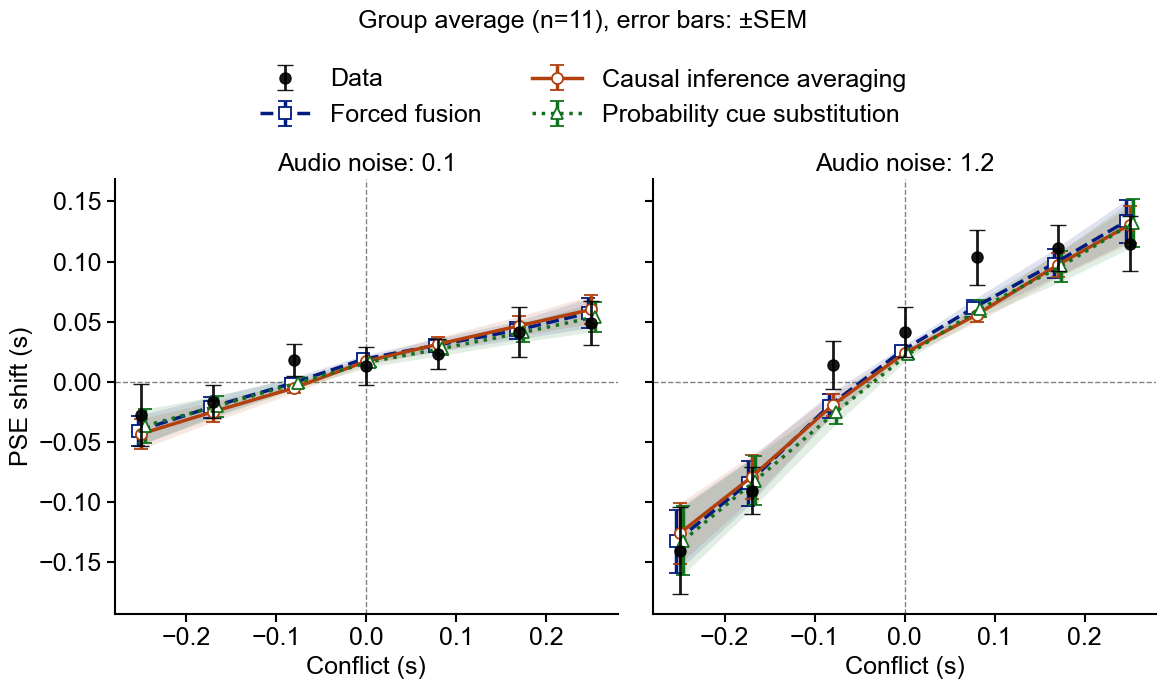

In [12]:
def plot_grouped_data_vs_models(grouped_data_stats, grouped_model_stats, parameterToPlot="mu", 
                                  show_grid=False, error_type="sem"):
    """
    Plot aggregated data and model predictions with error bars.
    
    Parameters
    ----------
    error_type : str
        'sem' - Standard error of the mean (SD / √n) - best for statistical inference
        'std' - Standard deviation across participants - shows individual variability
    """
    FONTSIZE = 18  # Unified font size for all text elements
    
    if grouped_data_stats is None or grouped_data_stats.empty:
        print("No aggregated data available to plot.")
        return None
    param_label_map = {
        "mu": "PSE shift (s)",
        "sigma": "Psychometric σ",
        "lambda": "Lapse (λ)",
    }
    if parameterToPlot not in param_label_map:
        raise ValueError("parameterToPlot must be one of 'mu', 'sigma', 'lambda'")
    
    # Choose which error column to use
    error_col = 'sem' if error_type == 'sem' else 'std'
    error_label = 'SEM' if error_type == 'sem' else 'SD'
    
    audio_levels = sorted(grouped_data_stats['audioNoise'].unique().tolist())
    if grouped_model_stats is not None and not grouped_model_stats.empty:
        audio_levels = sorted(set(audio_levels).union(set(grouped_model_stats['audioNoise'].unique())))
    n_cols = len(audio_levels)
    
    fig, axes = plt.subplots(1, n_cols, figsize=(12, 6), sharey=True)
    if n_cols == 1:
        axes = [axes]
    model_names = []
    model_color_lookup = {}
    model_offsets = {}
    if grouped_model_stats is not None and not grouped_model_stats.empty:
        model_names = sorted(grouped_model_stats['model'].unique())
        palette = sns.color_palette("dark", n_colors=max(3, len(model_names)))
        model_color_lookup = {model_names[i]: palette[i] for i in range(len(model_names))}
        # horizontal offsets prevent overlap when means coincide
        offset_span = 0.004
        mid = (len(model_names) - 1) / 2
        model_offsets = {model_names[i]: (i - mid) * offset_span for i in range(len(model_names))}
    model_display_name_map = {
        "lognorm": "Causal inference averaging",
        "fusionOnlyLognorm": "Forced fusion",
        "logLinearMismatch": "Log-linear measurement mismatch",
        "probabilityMatchingLogNorm": "Causal probability matching",
        "selection": "Causal selection",
        "switchingFree": "Probability cue substitution",
    }
    model_style_map = {
        "lognorm": {"linestyle": "-", "marker": "o"},
        "fusionOnlyLognorm": {"linestyle": "--", "marker": "s"},
        "switchingFree": {"linestyle": ":", "marker": "^"},
    }

    for ax, audio_noise in zip(axes, audio_levels):
        subset_data = grouped_data_stats[grouped_data_stats['audioNoise'] == audio_noise].sort_values('conflict')
        if not subset_data.empty:
            ax.errorbar(
                subset_data['conflict'],
                subset_data['mean'],
                yerr=subset_data[error_col],
                color='black',
                fmt='o',
                capsize=6,
                alpha=0.9,
                label='Data',
                zorder=6,
            )
        if model_names:
            for model_name in model_names:
                subset_model = grouped_model_stats[
                    (grouped_model_stats['audioNoise'] == audio_noise)
                    & (grouped_model_stats['model'] == model_name)
                ].sort_values('conflict')
                if subset_model.empty:
                    continue
                display_model_name = model_display_name_map.get(model_name, model_name)
                color = model_color_lookup[model_name]
                linestyle = model_style_map.get(model_name, {}).get('linestyle', '-')
                marker = model_style_map.get(model_name, {}).get('marker', 'o')
                x_vals = subset_model['conflict'].to_numpy(dtype=float)
                offset = model_offsets.get(model_name, 0.0)
                x_shifted = x_vals + offset
                means = subset_model['mean'].to_numpy(dtype=float)
                errors = subset_model[error_col].to_numpy(dtype=float)
                ax.fill_between(
                    x_shifted,
                    means - errors,
                    means + errors,
                    color=color,
                    alpha=0.12,
                    linewidth=0,
                    zorder=3,
                )
                ax.errorbar(
                    x_shifted,
                    means,
                    yerr=errors,
                    color=color,
                    linestyle=linestyle,
                    marker=marker,
                    markerfacecolor='white',
                    markeredgewidth=1.3,
                    capsize=5,
                    linewidth=2.5,
                    label=display_model_name,
                    zorder=4,
                )
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.axvline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel("Conflict (s)", fontsize=FONTSIZE)
        ax.set_title(f"Audio noise: {audio_noise}", fontsize=FONTSIZE)
        ax.tick_params(axis='both', labelsize=FONTSIZE)
        if show_grid:
            ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axes[0].set_ylabel(param_label_map[parameterToPlot], fontsize=FONTSIZE)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        # Use 2 columns to create multiple rows in legend
        fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False, 
                   bbox_to_anchor=(0.5, 1.10), fontsize=FONTSIZE)
    
    n_participants = grouped_data_stats['n_participants'].iloc[0]
    fig.suptitle(f"Group average (n={n_participants}), error bars: ±{error_label}", 
                 y=1.16, fontsize=FONTSIZE)
    plt.tight_layout(rect=(0, 0, 1, 1.05))
    plt.savefig(f"aggregated_{parameterToPlot}_vs_models_{error_type}.png", dpi=900, format='png', bbox_inches='tight')
    #return fig




# Use SEM for smaller, more appropriate error bars for group-level inference
plot_grouped_data_vs_models(grouped_data_stats, grouped_model_stats, parameter_to_plot, error_type="sem")
# Change to error_type="std" if you want to show between-participant variability

In [10]:
modelTypes
['switchingFree_sharedPrior', 'lognorm_sharedPrior']

['switchingFree_sharedPrior', 'lognorm_sharedPrior']

In [11]:
# Interactive plotting with model selection
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
def create_interactive_plot(selected_models, biasCorrection, verbose=False):
    """Create plots for selected models"""
    if not selected_models:
        print("Please select at least one model to display")
        return
    
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
        
    with plot_output:
        clear_output(wait=True)
        
        lenSubjs = len(participantIds)
        fig, axes = plt.subplots(lenSubjs, 2, figsize=(12, 6*lenSubjs))
        if lenSubjs == 1:
            axes = axes.reshape(1, -1)
        
        for pNum, participantID in enumerate(participantIds):
            for modelType in selected_models:
                               
                # Define model labels
                model_labels = {
                    'fusionOnlyLogNorm_sharedPrior': 'Forced fusion',
                    'logLinearMismatch_sharedPrior': 'Log-linear measurement mismatch',
                    'lognorm_sharedPrior': 'Causal inference averaging',
                    'probabilityMatchingLogNorm_sharedPrior': 'Causal probability matching',
                    'selection_sharedPrior': 'Causal selection',
                    'switchingFree_sharedPrior': 'Probability cue substitution',
                }
                # Get the descriptive label for the model
                model_label = model_labels.get(modelType, modelType)  # Default to modelType if not in the dictionary

                modelType_clean = modelType.split("_")[0]
 
                # 1- Read psychometric fits for real data
                real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
                try:
                    with open(real_fit_path, 'r') as f:
                        real_fit = json.load(f)
                    _print(f"Loaded real data psychometric fit for {participantID}")
                except Exception as e:
                    _print(f"Error loading real data psychometric fit for {participantID}: {e}")
                    continue

                # 2- Read psychometric fits for simulated data
                sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType_clean}_psychometricFits.json")
                try:
                    with open(sim_fit_path, 'r') as f:
                        sim_fit = json.load(f)
                    _print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType_clean}✅")
                except Exception as e:
                    _print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType_clean}: {e}")
                    continue
                
                # 3 - Read the bootstrapped fits for real data
                bootPath = participantID + "_dataFit_bootstrapped_params.json"
                dataBootsPath = os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
                try:
                    with open(dataBootsPath, 'r') as f:
                        content = f.read().strip()
                        dataBoots = json.loads(content) if content else {}
                    _print(f"Loaded bootstrapped params for {participantID}")
                except Exception as e:
                    _print(f"Error loading bootstrapped params for {participantID}: {e}")
                    continue

                # 4 - Read monte carlo fit results
                data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
                mc_fitter = monteCarloClass.OmerMonteCarlo(data)
                mc_fitter.modelName = modelType_clean
                mc_fitter.freeP_c = False
                mc_fitter.sharedLambda = True  # Using sharedLambda=True (LapseFix)
                mc_fitter.dataName = dataName 
                res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
                _print(f"Loaded saved fit results for {participantID}")
                mc_fitter.modelFit = res['fittedParams']
                mc_fitter.logLikelihood = res['logLikelihood']
                mc_fitter.aic = res['AIC']
                mc_fitter.bic = res['BIC']
                mc_fitter.nDataPoints = res['n_conditions']

                # Get model color (consistent color for each model)
                model_colors = {
                    'fusionOnlyLogNorm_sharedPrior': 'red',
                    'logLinearMismatch_sharedPrior': 'blue',
                    'lognorm_sharedPrior': 'green',
                    'probabilityMatchingLogNorm_sharedPrior': 'orange',
                    'selection_sharedPrior': 'purple',
                    'switchingFree_sharedPrior': 'brown'
                }
                model_color = model_colors.get(modelType, 'black')  # Default to black if modelType is not in the dictionary
                
                # Proceed to plot all fits together
                for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                    conflict_levels = []
                    mu_models = []

                    # Calculate baseline PSE at conflict == 0
                    baseline_pse = np.mean([mc_fitter.getParams(boot, 0, audioNoiseLevel)[1] for boot in dataBoots])
                    
                    for k, conflictLevel in enumerate(mc_fitter.uniqueConflict):
                        conflict_levels.append(conflictLevel)
                        
                        # Select the correct subplot
                        if lenSubjs == 1:
                            ax = axes[j]
                        else:
                            ax = axes[pNum, j]
                        
                        plt.sca(ax)
                        
                        if modelType == selected_models[0]:  # Only set title and plot data for first model
                            ax.set_title(f"Participant: {participantID}, Audio Noise: {audioNoiseLevel}")
                            
                            # Plot bootstrap data (only once)
                            bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                            if biasCorrection:
                                bootMus = np.array(bootMus) - baseline_pse  # Center around baseline
                            ax.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), 
                                      color="black", fmt='s', capsize=5, alpha=0.8, label='Data' if k == 0 else "")

                        # Plot model predictions
                        paramsSimDf = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)
                        muModel = paramsSimDf[1]
                        baseline_mu_model = mc_fitter.getParams(sim_fit['fitParams'], 0, audioNoiseLevel)[1]
                        if biasCorrection:
                            muModel -= baseline_mu_model  # Center around model baseline
                        mu_models.append(muModel)

                        ax.plot(conflictLevel, muModel, color=model_color,  linestyle='--', 
                               marker='o', markersize=10, alpha=0.7, label=f'{model_label}' if k == 0 else "")
                        
                        # Set common plot properties (only for first model to avoid repetition)
                        if modelType == selected_models[0]:
                            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
                            ax.tick_params(axis='both', labelsize=FONTSIZE)
                            if pNum == lenSubjs - 1:  # Only add xlabel to bottom plots
                                ax.set_xlabel("Conflict (ms)", fontsize=FONTSIZE)
                            if j == 0 and pNum==lenSubjs//2-1:  # Only add ylabel to left plots
                                ax.set_ylabel("PSE shift (ms)", fontsize=FONTSIZE)

                        # Inside the create_interactive_plot function, where the plot is being created
                        # Add this block after setting up the plot properties for each subplot
                        x_ticks = [-0.25, -0.167, -0.083, 0, 0.083, 0.167, 0.25]
                        x_tick_labels = ['-0.25', '-0.167', '-0.083', '0', '0.083', '0.167', '0.25']

                        # Set the x-axis ticks and labels
                        ax.set_xticks(x_ticks)
                        ax.set_xticklabels(x_tick_labels, fontsize=FONTSIZE)

                        # set limits for y-axis
                        ax.set_ylim([-0.2, 0.2])

                    # Convert lists to arrays and sort them for a proper line plot
                    conflict_levels = np.array(conflict_levels)
                    mu_models = np.array(mu_models)
                    sorted_indices = np.argsort(conflict_levels)
                    conflict_levels_sorted = conflict_levels[sorted_indices]
                    mu_models_sorted = mu_models[sorted_indices]
                    
                    # Select the correct subplot for continuous line
                    if lenSubjs == 1:
                        ax = axes[j]
                    else:
                        ax = axes[pNum, j]
                    
                    ax.plot(conflict_levels_sorted, mu_models_sorted, color=model_color, alpha=0.7, linestyle='--', linewidth=3, 
                        label=f'{model_label}' if k == 0 else "")  # Use model_label in the legend
  
                    # Remove top and right spines for a cleaner look
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
        
        # Add legend to the first subplot
        if lenSubjs == 1:
            axes[1].legend(loc='upper left', fontsize=10)
        else:
            axes[0, 0].legend(loc='upper left', fontsize=10)
        
        plt.tight_layout()
        plt.show()

# Create model selection checkboxes
model_checkboxes = []
for model in modelTypes:
    checkbox = widgets.Checkbox(
        value=(model == "lognorm_sharedPrior"),  # Default to first model selected
        description=model,
        disabled=False,
        layout=widgets.Layout(width='200px')
    )
    model_checkboxes.append(checkbox)

# Create update button
update_button = widgets.Button(
    description='Update Plot',
    disabled=False,
    button_style='success',
    tooltip='Click to update the plot with selected models',
)

# Create output widget for the plot
plot_output = widgets.Output()

biasCorrection=0
def on_button_click(b):
    selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]
    create_interactive_plot(selected_models, biasCorrection=biasCorrection)

update_button.on_click(on_button_click)

# Layout the widgets
checkbox_container = widgets.VBox(model_checkboxes)
control_panel = widgets.HBox([checkbox_container, widgets.VBox([update_button])])

print("Interactive Model Comparison Plot")
print("Select the models you want to compare and click 'Update Plot':")
display(control_panel)
display(plot_output)


# Initial plot with default selectioncreate_interactive_plot(selected_models, biasCorrection=biasCorrection)
selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]

Interactive Model Comparison Plot
Select the models you want to compare and click 'Update Plot':


Output()